In this homework you'll train a simple image classifier using using Pytorch. If you're not familiar with Pytorch please take a look at our [introduction to Pytorch notebook](https://colab.research.google.com/drive/1GO_YSErd9TjiH0R-hZ2XkKIfMbQK9Ask?usp=sharing). There are four parts to the homework:

1. Dataset class: you'll create a custom dataset class that you'll use to load the images for training. Your image transformations should be done in the dataset class.

2. Model design: in this section you'll design a simple CNN based model architecture to learn to predict image classes correctly.

3. Model training: train an image classifier using the model you designed in step 2. You'll need to instantiate a dataloader that uses an instance of your dataset class to iterate through the dataset for training.

4. Evaluation: load your model's weight and run inference on the dataset and report your result

In [1]:
import os
import tarfile

if not os.path.isfile('./data.tar.gz'):
    !wget 'http://cs.umd.edu/~pulkit/hw_3_data.tar.gz' -O data.tar.gz

with tarfile.open('./data.tar.gz', 'r:gz') as tar:
    tar.extractall(path='./')


--2024-07-10 16:38:37--  http://cs.umd.edu/~pulkit/hw_3_data.tar.gz
Resolving cs.umd.edu (cs.umd.edu)... 128.8.127.4
Connecting to cs.umd.edu (cs.umd.edu)|128.8.127.4|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://www.cs.umd.edu/~pulkit/hw_3_data.tar.gz [following]
--2024-07-10 16:38:38--  http://www.cs.umd.edu/~pulkit/hw_3_data.tar.gz
Resolving www.cs.umd.edu (www.cs.umd.edu)... 128.8.127.4
Reusing existing connection to cs.umd.edu:80.
HTTP request sent, awaiting response... 200 OK
Length: 7171530 (6.8M) [application/x-gzip]
Saving to: ‘data.tar.gz’

data.tar.gz         100%[===================>]   6.84M  2.19MB/s    in 3.1s    

2024-07-10 16:38:42 (2.19 MB/s) - ‘data.tar.gz’ saved [7171530/7171530]



In [2]:
import os
import pandas as pd
from collections import Counter
from PIL import Image

def analyze_dataset(csv_file):
    data_df = pd.read_csv(csv_file)

    # Analyze class distribution
    class_counts = Counter(data_df['class_name'])
    print("Class Distribution:")
    for class_name, count in class_counts.items():
        print(f"{class_name}: {count}")

    # Get the first image path directly from the CSV
    example_image_path = data_df.iloc[0]['image_path']
    with Image.open(example_image_path) as img:
        print(f"Image Dimensions: {img.size}, Channels: {img.mode}")

    # Inspect sample images directly from the CSV
    sample_images = data_df['image_path'].sample(3)
    for img_path in sample_images:
        print(f"Sample Image: {img_path}")
        with Image.open(img_path) as img:
            img.show()

# Example usage
analyze_dataset('data/csvs/train.csv')


Class Distribution:
cat: 300
lemon: 300
basketball: 300
pretzel: 300
umbrella: 300
dog: 300
bear: 300
bus: 300
pizza: 300
guinea_pig: 300
Image Dimensions: (64, 64), Channels: RGB
Sample Image: data/train/3k6g6axy.JPEG
Sample Image: data/train/o9hzb98e.JPEG
Sample Image: data/train/67pvqf68.JPEG


### Dataset class

In [3]:
import torch
from torch.utils.data import Dataset
import pandas as pd
import os
import torchvision
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, csv_path, data_root, transform=None, device='gpu'):
        self.transform = transform
        self.root_path = data_root
        self.device = device

        # Read the CSV file
        data = pd.read_csv(csv_path)

        # Get the image paths from the CSV
        self.image_paths = [os.path.join(self.root_path, img_path) for img_path in data['image_path']]

        # Get the class ids if they exist in the CSV
        if 'class_id' in data.columns:
            self.class_ids = data['class_id'].tolist()
        else:
            self.class_ids = None

        # Get the image names from the CSV
        self.image_names = data['image_name'].tolist()

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        rel_img_path = self.image_paths[idx]
        image_name = self.image_names[idx]

        # Read the image file
        img = read_image(rel_img_path, mode=torchvision.io.image.ImageReadMode.RGB)

        # Apply transformations to the image
        if self.transform:
            img = self.transform(img)

        # Return based on whether the dataset is for testing or training
        if self.class_ids is None: # for testing purposes
            return img, image_name, rel_img_path
        else:
            class_id = torch.tensor(self.class_ids[idx], dtype=torch.long)
            return img.to(self.device), class_id.to(self.device)


cuda available


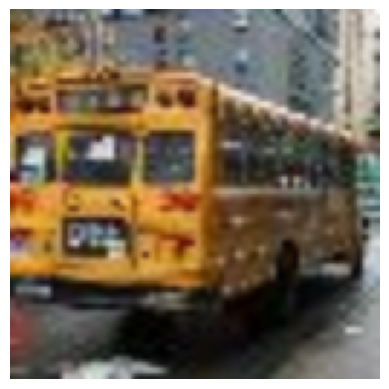

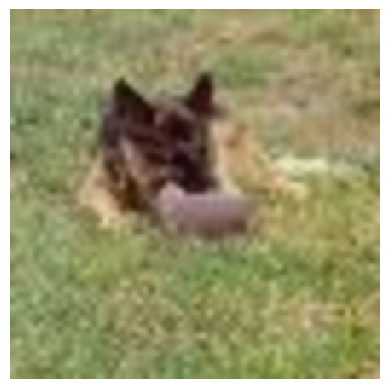

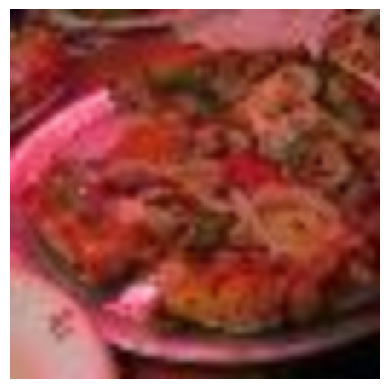

In [4]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.transforms as T

def plot_image(img, title=None):
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Transformations to apply to the images
# transforming images to a tensor
transform = transforms.Compose([
    transforms.ToPILImage(),
    #transforms.CenterCrop((64, 64)),  # Center crop the images to 64x64
    transforms.Resize((128, 128)), # Resize images to 128x128
    transforms.ToTensor() # Convert images to PyTorch tensors
])

if torch.cuda.is_available():
    device = torch.device('cuda')
    print("cuda available")
else:
    device = torch.device('cpu')
    print("cpu")

# TODO: Create an instance of the CustomImageDataset class for the training dataset
#dataset = CustomImageDataset(csv_path='data/csvs/test.csv', data_root='content', transform=transform)
dataset = CustomImageDataset(csv_path='/content/data/csvs/test.csv', data_root='.', transform=transform, device=device)

# TODO: Show the first 3 images from the dataset
for i in range(3):
    # img, _ = dataset[i]  # Get image tensor from dataset
    img, _, _= dataset[i]

    img = img.permute(1, 2, 0)  # Rearrange dimensions for visualization
    plot_image(img)

In [5]:
len(dataset)

1500

### Model definition

Define your image classifier model here. Since we're working with images, you should consider an convolution neural network type model architecture. Start simple and make it more complex if you need to once you have something working.

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassifier(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        # Conv layers with increased depth
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1) # Padding to keep dim
        self.bn1 = nn.BatchNorm2d(32)               # Batch norm
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 16 * 16, 512)     # Adjusted for depth
        self.drop = nn.Dropout(0.5)                 # Dropout for overfitting
        self.fc2 = nn.Linear(512, n_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        x = x.view(-1, 128 * 16 * 16)               # Flatten output
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)              # Softmax for stability

model = ImageClassifier(n_classes=10)
print(model)

ImageClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=512, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


### Training

In [7]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.optim import Adam
import torchvision.transforms as T
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Feel free to try other batch sizes. The batch size is usually a power of 2.
batch_size = 16

# You can try other learning rates to see how it affects the training.
# smaller learning rate means better training
learning_rate = 1e-5

# Try to explore different transformation functions. You can use transformations
# to make your model more robust to translation, color changes etc. This is a good
# article that explains some transformations available in Pytorch
# https://pytorch.org/vision/stable/transforms.html. You can use transformations
# to augment/"increase" your training data.bw

#Added transforms MAY COMMENT OUT****
transform = T.Compose([
    T.ToPILImage(),
    T.Resize((128, 128)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

img_root = "./"

# TODO: Create an instance of the CustomImageDataset class for the training and validation datasets
train_set = CustomImageDataset(csv_path='data/csvs/train.csv', data_root=img_root, transform=transform, device=device)
val_set = CustomImageDataset(csv_path='data/csvs/val.csv', data_root=img_root, transform=transform, device=device)

# TODO: Create two dataloaders for bothe datasets.
# TODO: Shuffle the training dataloader. This is important to prevent the model from learning the order of the data.

# need to shuffle?
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size)
print('val_loader')

# TODO: Initialize your model
n_classes = 10
model = ImageClassifier(n_classes).to(device)

# TODO: Initialize the optimizer. Feel free to try other optimizers in the torch.optim
# module.
# Hint: the Adam optimizer and its variants are the staple these days.

# learning_rate = 1e-4
optimizer = Adam(model.parameters(), lr=learning_rate)

# TODO: Instantiate the loss function.
# Hint: Cross entropy loss works great for classification tasks like this one.
# Reading up on what loss function to use for what task could be informative


# TRIED NEW LOSS FN, MAY COMMENT OUT****
#loss_fn = nn.NLLLoss().to(device)
loss_fn = nn.CrossEntropyLoss().to(device)

# Training loop
eval_every = 2

# Consider training for longer. Keep an eye on the validation loss and decide
# on what works best for you.
n_epochs = 25
val_loss_values = []
training_loss_values = []
eval_epochs = []

for epoch in range(n_epochs):
    print('epoch', epoch)
    # set your model to training mode. This is important if you're using normalization
    # or dropout
    model.train()
    total_train_loss = 0
    for img, label in tqdm(train_loader):
        img, label = img.to(device), label.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # TODO: Make a forward pass (predict the class of the image)
        # get predicted values from training set
        pred = model(img)
        #print('pred', pred)

        # Calculate the loss
        loss = loss_fn(pred, label)
        #print('loss', loss)
        loss.backward()
        optimizer.step()
        #loss = criterion(pred, label)
        total_train_loss += loss.item()

    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for img, label in tqdm(val_loader):
            img, label = img.to(device), label.to(device)
            pred = model(img)
            val_loss = loss_fn(pred, label)
            total_val_loss += val_loss.item()

    val_loss_avg = total_val_loss / len(val_loader)

    print(f"Epoch {epoch}: Train Loss: {total_train_loss / len(train_loader):.4f}, Val Loss: {val_loss:.4f}")
    eval_epochs.append(epoch)
    training_loss_values.append(loss.item())
    val_loss_values.append(val_loss.item())


# Save your model's weights
torch.save(model.state_dict(), "model.pth")

val_loader
epoch 0


100%|██████████| 32/32 [00:02<00:00, 13.58it/s]


Epoch 0: Train Loss: 2.1241, Val Loss: 1.9725
epoch 1


100%|██████████| 32/32 [00:01<00:00, 17.10it/s]


Epoch 1: Train Loss: 1.8933, Val Loss: 2.0841
epoch 2


100%|██████████| 32/32 [00:01<00:00, 17.20it/s]


Epoch 2: Train Loss: 1.8060, Val Loss: 1.5369
epoch 3


 44%|████▎     | 82/188 [00:06<00:08, 12.05it/s]


KeyboardInterrupt: 

### Plot your training and validation loss

In [ ]:
# Plot the training and validation loss
plt.plot(eval_epochs, training_loss_values, label='Training loss')
plt.plot(eval_epochs, val_loss_values, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

### Test your model against the validation dataset
This should give you a rough idea on how your model will do on the test set that you don't have labels for.
This section is not required and is only provided as a sanity check for you

In [ ]:
## Load from your saved model
import numpy as np
import torch

# Load from your saved model using torch.load
model = ImageClassifier(n_classes)
model_state_dict = torch.load("./model.pth")
model.load_state_dict(model_state_dict)
model.to(device)

# set model to inference mode
model.eval()
batch_size = 1

# Load the validation dataset
test_dataset = CustomImageDataset(csv_path='data/csvs/val.csv', data_root=img_root, transform=transform, device=device)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

preds = []
with torch.no_grad():
    for img, label in tqdm(test_loader):
        img = img.to(device)  # Move the input data to device
        pred = model(img)
        _, pred_class = torch.max(pred, 1)
        preds.append(pred_class.item())


# Get the true labels for the validation dataset
true_labels = test_dataset.class_ids
print('true_labels', true_labels)

# accuracy = (true_labels == torch.tensor(preds)).float().mean().item()
accuracy = (torch.tensor(true_labels) == torch.tensor(preds)).float().mean().item()
print(f"Accuracy: {accuracy}")

### Evaluation
Evaluate your model on the test dataset and create a CSF file. This is the file you need to submit.
> Important: make sure the prediction file has the columns: image_name, prediction, image_path

In [ ]:
# Load the CSV file to inspect its contents
import pandas as pd

df = pd.read_csv("predictions.csv")
print(df.head())
print(f"Total predictions: {len(df)}")  # Check number of predictions


In [ ]:
import pandas as pd
from torch.utils.data import DataLoader

# Load the model
model = ImageClassifier(n_classes)
model_state_dict = torch.load("./model.pth")
model.load_state_dict(model_state_dict)
model.to(device)
model.eval()

# Load the test dataset
test_dataset = CustomImageDataset(csv_path='data/csvs/test.csv', data_root='./', transform=transform, device=device)
test_loader = DataLoader(test_dataset, batch_size=16)

# Make predictions on the test data and check for missing images
final_preds = []
missing_images = []
with torch.no_grad():
    for imgs, img_names, img_paths in tqdm(test_loader):
        imgs = imgs.to(device)
        preds = model(imgs)
        _, pred_classes = torch.max(preds, 1)

        # Save predictions for each image in the batch
        batch_preds = [
            (img_name, pred_class.item(), img_path)
            for img_name, pred_class, img_path in zip(img_names, pred_classes, img_paths)
        ]
        final_preds.extend(batch_preds)

# Log missing images
if missing_images:
    print(f"Missing Images: {len(missing_images)}")
    for missing_img in missing_images:
        print(missing_img)

# Check that the total predictions match the total dataset size
assert len(final_preds) == len(test_dataset), "Mismatch between predictions and dataset size!"

# Save predictions to a CSV file
df = pd.DataFrame(final_preds, columns=["image_name", "prediction", "image_path"])
df.to_csv("predictions.csv", index=False)


In [ ]:
# DO NOT MODIFY
test_prediction = pd.DataFrame(final_preds, columns=['image_name', 'prediction', 'image_path'])
test_prediction.to_csv('prediction.csv')

# You can comment these lines out if you're running the notebook locally
from google.colab import files
files.download('prediction.csv')

Upload *prediction.csv* on gradescope

Utility Functions to Inspect Database

In [ ]:
import os

train_path = 'data/train'
val_path = 'data/val'
csv_path = 'data/csvs'


def count_images(folder_path):
    return sum([len(files) for r, d, files in os.walk(folder_path)])

total_train = count_images(train_path)
total_val = count_images(val_path)
total_test = count_images(csv_path)

print(f"Total Images: Train = {total_train}, Val = {total_val}, Test = {total_test}")


In [ ]:
import os

def print_directory_structure(path, level=0):
    print(" " * (level * 2) + os.path.basename(path) + "/")
    for entry in os.listdir(path):
        full_path = os.path.join(path, entry)
        if os.path.isdir(full_path):
            print_directory_structure(full_path, level + 1)
        else:
            print(" " * ((level + 1) * 4) + entry)

base_path = "./"  # Adjust to your base path
print_directory_structure(base_path)


In [ ]:
data_df = pd.read_csv('data/csvs/train.csv')
print(data_df.columns)
print(data_df['image_path'].head())
